# Plot example

In [1]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
indir = '/data/hba/compartment_majortype/'
outdir = '/home/jzhou_salk_edu/sky_workdir/hba/compartment_majortype/'


In [5]:
binall = np.load(f'{outdir}binfilter_raw.npy', allow_pickle=True)

In [4]:
res = 100000
chrom_size_path = f'/home/jzhou_salk_edu/sky_workdir/hba/ref/hg38.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:23]


In [6]:
cpg = pd.read_csv('/home/jzhou_salk_edu/sky_workdir/hba/ref/hg38.100kbin.CpG.txt', header=0, index_col=3, sep='\t')
cpg['CpG_density'] = cpg['14_user_patt_count'] / (cpg['13_seq_len'] - cpg['11_num_N'])


In [7]:
chrom = 'chr5'
ll, rr = 800, 1200
n_bins = (int(chrom_sizes.loc[chrom]) // res + 1)
binfilter = binall[4]


In [8]:
Qall = []
for ct in ['L5_IT', 'Sst', 'ASC', 'MGC']:
    cool = cooler.Cooler(f'{indir}{ct}/{ct}.Q.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
    Q = Q - np.diag(np.diag(Q))
    rowsum = Q.sum(axis=0)
    # thres = np.percentile(rowsum[rowsum>0], 50) * 2 - np.percentile(rowsum[rowsum>0], 99)
    # binfilter = (rowsum>thres)
    # binall.append(binfilter)
    Q = Q[binfilter][:, binfilter]
    Qall.append(Q)
    print(ct)


L5_IT
Sst
ASC
MGC


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


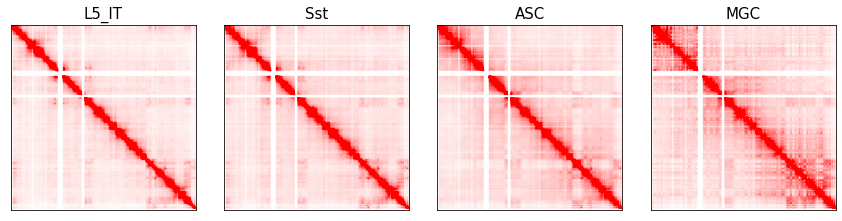

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))
for i in range(4):
    ax = axes[i]
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binfilter, binfilter)] = Qall[i]
    ax.imshow(tmp, cmap='bwr', vmin=-0.0015, vmax=0.0015)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(['L5_IT', 'Sst', 'ASC', 'MGC'][i], fontsize=15)

plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_Q_decay.pdf', transparent=True)


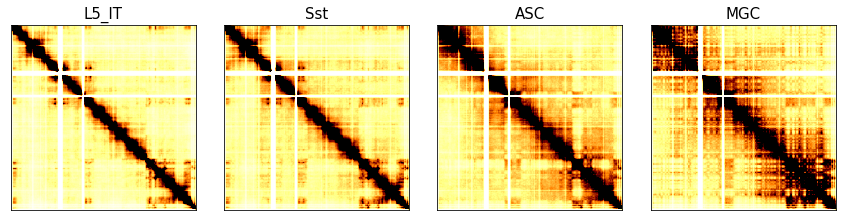

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))
for i in range(4):
    ax = axes[i]
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binfilter, binfilter)] = Qall[i]
    ax.imshow(tmp, cmap='afmhot_r', vmin=0, vmax=0.0008)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(['L5_IT', 'Sst', 'ASC', 'MGC'][i], fontsize=15)

plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_Q_decay.pdf', transparent=True)


In [11]:
comp = pd.read_hdf(f'{indir}comp_impute_mergerawpca.hdf', key='data')

Call = []
pcall = []
for k,ct in enumerate(['L5_IT', 'Sst', 'ASC', 'MGC']):
    Q = Qall[k].copy()
    decay = np.array([np.mean(np.diag(Q, i)) for i in range(Q.shape[0])])
    E = np.zeros(Q.shape)
    row, col = np.diag_indices(E.shape[0])
    E[row, col] = 1
    for i in range(1, E.shape[0]):
        E[row[:-i], col[i:]] = (Q[row[:-i], col[i:]] + 1e-5) / (decay[i] + 1e-5)
    E = E + E.T
    C = np.corrcoef(np.log2(E + 0.001))
    Call.append(C)
    tmp = comp.loc[(comp.index.str.split('-').str[0]==chrom), ct]
    tmp.index = [int(xx.split('-')[1]) for xx in tmp.index]
    pcall.append(tmp[np.where(binfilter)[0]].values)
    print(ct)


L5_IT
Sst
ASC
MGC


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


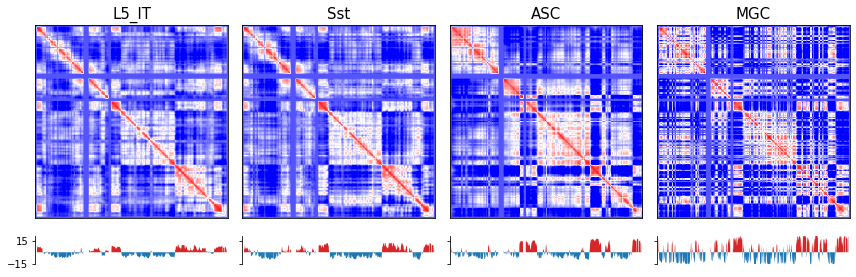

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), gridspec_kw={'height_ratios':[4,0.5]}, sharex='col', sharey='row')
for i in range(4):
    ax = axes[0,i]
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binfilter, binfilter)] = Call[i]
    ax.imshow(tmp, cmap='bwr', vmin=-0.2, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(['L5_IT', 'Sst', 'ASC', 'MGC'][i], fontsize=15)

    ax = axes[1,i]
    # ax.set_title('PC1', fontsize=10)
    sns.despine(bottom=True, ax=ax)
    tmp = np.zeros(n_bins)
    tmp[binfilter] = pcall[i]# / np.std(pcall[i])
    x, y = np.arange(n_bins), tmp
    # x, y = np.arange(pcall[i].shape[0]), pcall[i]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([-15, 15])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_compimpute.pdf', transparent=True)


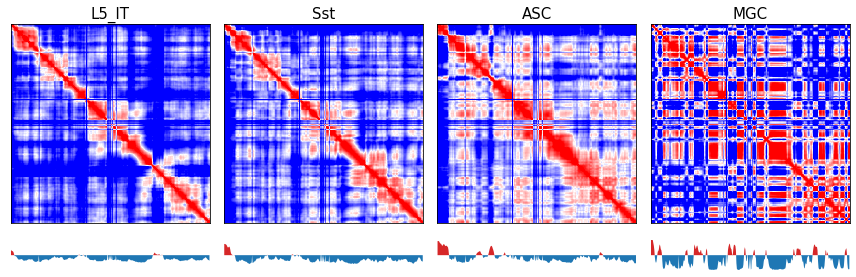

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), gridspec_kw={'height_ratios':[4,0.5]}, sharex='col', sharey='row')
for i in range(4):
    ax = axes[0,i]
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binfilter, binfilter)] = Call[i]    
    ax.imshow(tmp[ll:rr,ll:rr], cmap='bwr', vmin=0.2, vmax=0.8)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(['L5_IT', 'Sst', 'ASC', 'MGC'][i], fontsize=15)

    ax = axes[1,i]
    # ax.set_title('PC1', fontsize=10)
    sns.despine(bottom=True, left=True, ax=ax)
    tmp = np.zeros(n_bins)
    tmp[binfilter] = pcall[i]
    x, y = np.arange(rr-ll), tmp[ll:rr]
    # x, y = np.arange(rr-ll), pcall[i][ll:rr]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_compimpute_zoomin.pdf', transparent=True)


In [14]:
pca = PCA(n_components=2)

In [15]:
Gall = []
Gpc = []
for i,ct in enumerate(['L5_IT', 'Sst', 'ASC', 'MGC']):
    cool = cooler.Cooler(f'{indir}{ct}/{ct}.CGcorr.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
    Q = Q - np.diag(np.diag(Q))
    Q = Q[binfilter][:, binfilter]
    Gall.append(Q)
    pc = pca.fit_transform(Q)
    cpgtmp = cpg.loc[cpg['#1_usercol']==chrom, 'CpG_density'].values[binfilter]
    if pearsonr(cpgtmp, pc[:,0])[0]>0:
        pc = pc[:,0]
    else:
        pc = -pc[:,0]
    Gpc.append(pc)
    print(ct)


L5_IT
Sst
ASC
MGC


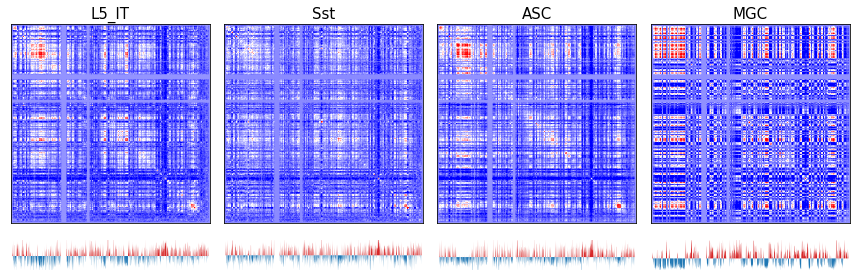

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), gridspec_kw={'height_ratios':[4,0.5]}, sharex='col')
for i in range(4):
    ax = axes[0,i]
    tmp = np.zeros((n_bins, n_bins)) + (np.percentile(Gall[i], 5) + np.percentile(Gall[i], 95)) / 2
    tmp[np.ix_(binfilter, binfilter)] = Gall[i]
    ax.imshow(tmp, cmap='bwr', vmin=np.percentile(Gall[i], 30), vmax=np.percentile(Gall[i], 95))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(['L5_IT', 'Sst', 'ASC', 'MGC'][i], fontsize=15)

    ax = axes[1,i]
    # ax.set_title('PC1', fontsize=10)
    sns.despine(bottom=True, left=True, ax=ax)
    tmp = np.zeros(n_bins)
    tmp[binfilter] = Gpc[i]
    x, y = np.arange(n_bins), tmp
    # x, y = np.arange(Gpc[i].shape[0]), Gpc[i]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_CGcorr_impute.pdf', transparent=True)



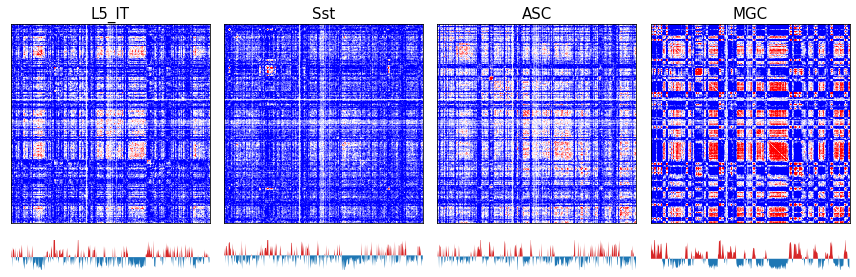

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), gridspec_kw={'height_ratios':[4,0.5]}, sharex='col')
for i in range(4):
    ax = axes[0,i]
    tmp = np.zeros((n_bins, n_bins)) + 0.06
    tmp[np.ix_(binfilter, binfilter)] = Gall[i]    
    ax.imshow(tmp[ll:rr, ll:rr], cmap='bwr', vmin=0, vmax=0.12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(['L5_IT', 'Sst', 'ASC', 'MGC'][i], fontsize=15)

    ax = axes[1,i]
    # ax.set_title('PC1', fontsize=10)
    sns.despine(bottom=True, left=True, ax=ax)
    tmp = np.zeros(n_bins)
    tmp[binfilter] = Gpc[i]
    x, y = np.arange(rr-ll), tmp[ll:rr]
    # x, y = np.arange(Gpc[i][ll:rr].shape[0]), Gpc[i][ll:rr]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_CGcorr_impute_zoomin.pdf', transparent=True)



In [18]:
Hall = []
Hpc = []
for i,ct in enumerate(['L5_IT', 'Sst', 'ASC', 'MGC']):
    cool = cooler.Cooler(f'{indir}{ct}/{ct}.CHcorr.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
    Q = Q - np.diag(np.diag(Q))
    Q = Q[binfilter][:, binfilter]
    Hall.append(Q)
    pc = pca.fit_transform(Q)
    cpgtmp = cpg.loc[cpg['#1_usercol']==chrom, 'CpG_density'].values[binfilter]
    if pearsonr(cpgtmp, pc[:,0])[0]>0:
        pc = pc[:,0]
    else:
        pc = -pc[:,0]
    Hpc.append(pc)
    print(ct)



L5_IT
Sst
ASC
MGC


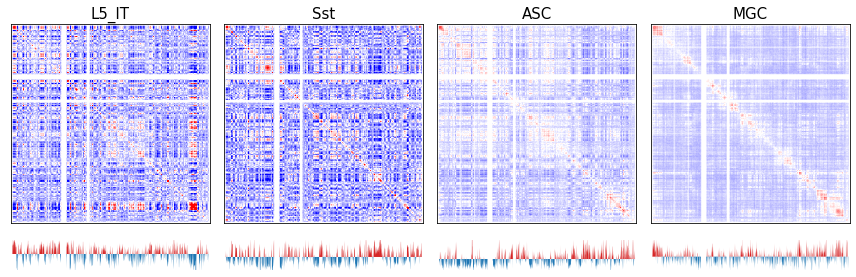

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), gridspec_kw={'height_ratios':[4,0.5]}, sharex='col')
for i in range(4):
    ax = axes[0,i]
    tmp = np.zeros((n_bins, n_bins)) + 0.05
    tmp[np.ix_(binfilter, binfilter)] = Hall[i]
    ax.imshow(tmp, cmap='bwr', vmin=-0.1, vmax=0.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(['L5_IT', 'Sst', 'ASC', 'MGC'][i], fontsize=15)

    ax = axes[1,i]
    # ax.set_title('PC1', fontsize=10)
    sns.despine(bottom=True, left=True, ax=ax)
    tmp = np.zeros(n_bins)
    tmp[binfilter] = Hpc[i]
    x, y = np.arange(n_bins), tmp
    # x, y = np.arange(Hpc[i].shape[0]), Hpc[i]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_comp.pdf', transparent=True)



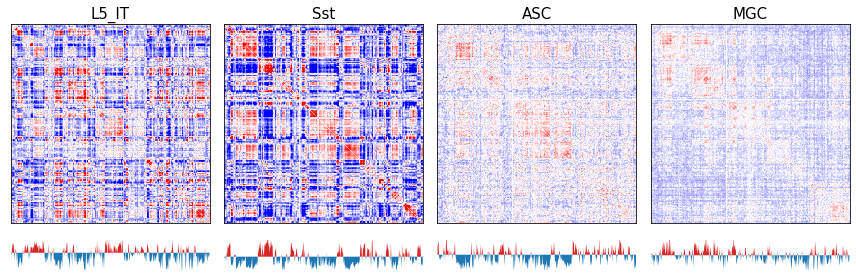

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), gridspec_kw={'height_ratios':[4,0.5]}, sharex='col')
for i in range(4):
    ax = axes[0,i]
    tmp = np.zeros((n_bins, n_bins)) + 0.05
    tmp[np.ix_(binfilter, binfilter)] = Hall[i]    
    ax.imshow(tmp[ll:rr, ll:rr], cmap='bwr', vmin=-0.1, vmax=0.2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(['L5_IT', 'Sst', 'ASC', 'MGC'][i], fontsize=15)

    ax = axes[1,i]
    # ax.set_title('PC1', fontsize=10)
    sns.despine(bottom=True, left=True, ax=ax)
    tmp = np.zeros(n_bins)
    tmp[binfilter] = Hpc[i]
    x, y = np.arange(rr-ll), tmp[ll:rr]
    # x, y = np.arange(Gpc[i][ll:rr].shape[0]), Gpc[i][ll:rr]
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.set_yticks([])
    ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_CGcorr_impute_zoomin.pdf', transparent=True)

